In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn import preprocessing
import pandas as pd
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
sns.set(color_codes=True)
%matplotlib inline

from clean_data import CLEANED_DATA_DIR, RAW_DATA_DIR

PLOT_DIR = "Images"
MODEL_DIR = "Model Output"

In [3]:
cached_cleaned = os.path.join(CLEANED_DATA_DIR, "cleaned_data.csv")
data = pd.read_csv(cached_cleaned,
                   parse_dates=["RECORDED_A"])

# Visualizing the data

With the loaded data, we make plots to get an idea of the relationship between speed and
other variables in the model; in particular, slope and distance to intersection.

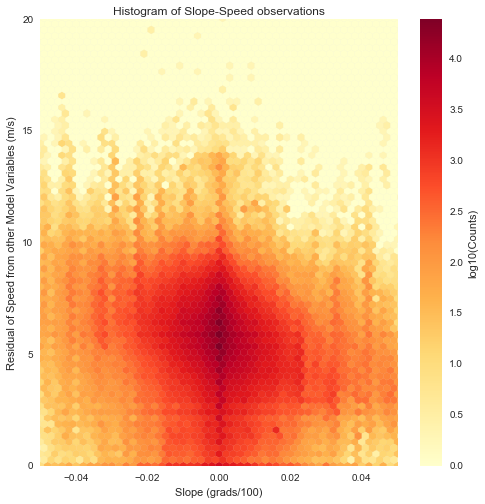

In [24]:
fig = plt.figure(figsize=(8,8))
plt.hexbin("SLOPE_TF", "SPEED", data=data, bins="log", cmap=plt.cm.YlOrRd)
plt.xlim(-0.05, 0.05)
plt.ylim(0, 20)
plt.xlabel("Slope (grads/100)")
plt.ylabel("Residual of Speed from other Model Variables (m/s)")
plt.title("Histogram of Slope-Speed observations")
cbar = plt.colorbar()
cbar.set_label("log10(Counts)")

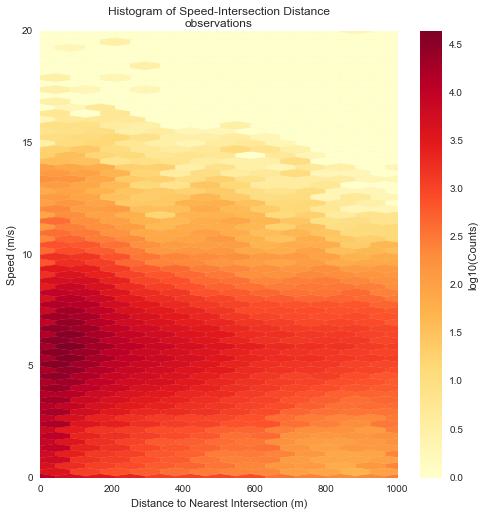

In [43]:
plt.figure(figsize=(8,8))
plt.hexbin(data["SIG_DIST"], data["SPEED"], bins="log", cmap=plt.cm.YlOrRd)
plt.xlim(0,1000)
plt.ylim(0, 20)
plt.xlabel("Distance to Nearest Intersection (m)")
plt.ylabel("Speed (m/s)")
plt.title("Histogram of Speed-Intersection Distance\nobservations")
cbar = plt.colorbar()
cbar.set_label("log10(Counts)")

# Fitting the relationship for cyclist speed

Now, we read in the cleaned data, and run a linear model on the speed,
regressed on the explanatory_road variables defined below:

In [4]:
explanatory_road = ("bike_lanes", "sharrows", "bike_path", "SIG_DIST <= 35", "volume", "VDF",
                    "I(volume/(LANES*speed_limit))", "speed_limit", "LANES", "C(RDCLASS)", "SLOPE_TF")

formula = "SPEED ~ " + " + ".join(explanatory_road)
model = sm.ols(formula=formula, data=data).fit()

data["residual"] = model.resid
data["predicted"] = model.fittedvalues

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SPEED   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                 2.326e+04
Date:                Wed, 31 Aug 2016   Prob (F-statistic):               0.00
Time:                        22:19:29   Log-Likelihood:            -3.9550e+06
No. Observations:             1917649   AIC:                         7.910e+06
Df Residuals:                 1917635   BIC:                         7.910e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
Intercept                             5.5096      0.026    214.661      0.000         5.459     5.560
bike_lanes[T.True]                    0.5177      0.004    129.104      0.000         0.510     0.526
sharrows[T.True]                      0.4317      0.005     83.299      0.000         0.422     0.442
bike_path[T.True]                     1.2244      0.005    236.845      0.000         1.214     1.235
SIG_DIST <= 35[T.True]               -1.2759      0.004   -331.362      0.000        -1.283    -1.268
C(RDCLASS)[T.1]                      -0.2985      0.009    -34.155      0.000        -0.316    -0.281
C(RDCLASS)[T.2]                      -0.1695      0.008    -20.032      0.000        -0.186    -0.153
C(RDCLASS)[T.3]                      -0.5850      0.007    -85.705      0.000        -0.598    -0.572
volume                            -9.506e-05    1.3e-05     -7.339      0.000        -0.000 -6.97e-05
VDF                                  -0.0109      0.000    -82.393      0.000        -0.011    -0.011
I(volume / (LANES * speed_limit))    -0.0186      0.001    -16.081      0.000        -0.021    -0.016
speed_limit                           0.0237      0.000     63.443      0.000         0.023     0.024
LANES                                -0.0334      0.004     -7.613      0.000        -0.042    -0.025
SLOPE_TF                            -25.3317      0.089   -285.519      0.000       -25.506   -25.158
==============================================================================
Omnibus:                    59651.955   Durbin-Watson:                   0.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           101106.655
Skew:                          -0.278   Prob(JB):                         0.00
Kurtosis:                       3.978   Cond. No.                     2.84e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
normalized_data = data.copy()
normalize_vars = ["SPEED", "volume", "speed_limit", "SLOPE_TF", "VDF", "LANES"]
normalized_data.loc[:, normalize_vars] = preprocessing.StandardScaler().fit_transform(data.loc[:, normalize_vars])

model = sm.ols(formula=formula, data=normalized_data).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  SPEED   R-squared:                       0.136
Model:                            OLS   Adj. R-squared:                  0.136
Method:                 Least Squares   F-statistic:                 2.327e+04
Date:                Wed, 31 Aug 2016   Prob (F-statistic):               0.00
Time:                        19:19:43   Log-Likelihood:            -2.5806e+06
No. Observations:             1917649   AIC:                         5.161e+06
Df Residuals:                 1917635   BIC:                         5.161e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------------------
Intercept                             0.1319      0.003     38.531      0.000         0.125     0.139
bike_lanes[T.True]                    0.2517      0.002    128.579      0.000         0.248     0.256
sharrows[T.True]                      0.2149      0.003     84.686      0.000         0.210     0.220
bike_path[T.True]                     0.5973      0.003    236.646      0.000         0.592     0.602
SIG_DIST <= 35[T.True]               -0.6241      0.002   -331.940      0.000        -0.628    -0.620
C(RDCLASS)[T.1]                      -0.1454      0.004    -34.092      0.000        -0.154    -0.137
C(RDCLASS)[T.2]                      -0.0835      0.004    -20.227      0.000        -0.092    -0.075
C(RDCLASS)[T.3]                      -0.2852      0.003    -85.561      0.000        -0.292    -0.279
volume                               -0.0529      0.001    -56.568      0.000        -0.055    -0.051
VDF                                  -0.1309      0.002    -83.584      0.000        -0.134    -0.128
I(volume / (LANES * speed_limit))     0.0010   4.66e-05     21.363      0.000         0.001     0.001
speed_limit                           0.0678      0.001     65.002      0.000         0.066     0.070
LANES                                 0.0027      0.001      3.660      0.000         0.001     0.004
SLOPE_TF                             -0.1917      0.001   -285.626      0.000        -0.193    -0.190
==============================================================================
Omnibus:                    59438.921   Durbin-Watson:                   0.120
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           100864.122
Skew:                          -0.276   Prob(JB):                         0.00
Kurtosis:                       3.978   Cond. No.                         227.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Where the intersection starts

The model above does not model how cyclists behave around intersections at any granuar level. Instead, it assumes that signalized intersections have a constant effect on speed when cyclists are within a certain distance of them.
This makes intersections a "black box" in this model.  It would be very interesting to see
an analysis in the future that tries to do a better job of modelling how cyclists' speed
varies around intersections (e.g. taking into account what kind of turn they do, how far away
they are from the intersection on approach/departure from it, what kind of intersection it is,
etc.).

Below is a method for selecting a cutoff for the "black box" intersection
dummy variable.  The model is trained using a range of cutoff distances, and the distance that gives the highest model R-squared is the ideal distance to use in the model.  It can be seen that the R-squared peaks at a cutoff of 35m on either side of the intersection, so this is the value that we use in our model.

Note that the model $R^2$ behaves quite smoothly as a function of the cutoff distance.

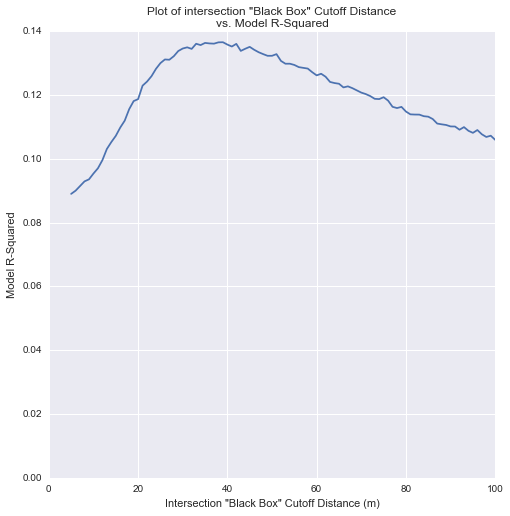

In [35]:
cutoffs = range(5, 101, 1)
r_squareds = []
for cutoff in cutoffs:
    explanatory_road = ("bike_lanes", "sharrows", "bike_path", "SIG_DIST <= %d"%cutoff, "VDF", "volume",
                        "I(volume/(LANES*speed_limit))", "speed_limit", "LANES", "C(RDCLASS)", "SLOPE_TF")
    formula = "SPEED ~ " + " + ".join(explanatory_road)
    test_model = sm.ols(formula=formula, data=data.sample(frac=0.5)).fit()
    
    r_squared = test_model.rsquared
    r_squareds.append(r_squared)

plt.figure(figsize=(8,8))
plt.plot(cutoffs, r_squareds)
plt.ylim(0,)
plt.title('Plot of intersection "Black Box" Cutoff Distance\nvs. Model R-Squared')
plt.xlabel('Intersection "Black Box" Cutoff Distance (m)')
plt.ylabel('Model R-Squared')

# Testing model assumptions

We test for heteroskedasticity in our data using the Breusch-Pagan test using the following code.

Note that while the model i statistically significant, the $R^2$ of the model is
very small.  We are working with several million data points, so we have enough data for
even a very small effect size to be statistically significant.  However, with such a
small R-squared, we can be pretty confident that heteroskedasticity is not hugely 
affecting our estimates.

In [114]:
hetero_model = sm.ols(formula="I(residual**2) ~ predicted + I(predicted**2)", 
                      data=data).fit()

hetero_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       I(residual ** 2)   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2999.
Date:                Sat, 20 Aug 2016   Prob (F-statistic):               0.00
Time:                        01:00:14   Log-Likelihood:            -6.2658e+06
No. Observations:             1917649   AIC:                         1.253e+07
Df Residuals:                 1917646   BIC:                         1.253e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept            15.4738      0.155    100.095      0.000        15.171    15.777
predicted            -4.5575      0.059    -77.324      0.000        -4.673    -4.442
I(predicted ** 2)     0.4324      0.006     77.346      0.000         0.421     0.443
==============================================================================
Omnibus:                  2363108.713   Durbin-Watson:                   0.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       3284325997.244
Skew:                           5.863   Prob(JB):                         0.00
Kurtosis:                     205.403   Cond. No.                     1.12e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.12e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Plotting residuals against predictors

While the very small effect size in the above regression indicates that the data is not particularly heteroskedastic with respect to the predicted value, plotting the residuals against the distance to intersection below shows that the variance in cyclist speed is highly dependent on their distance to the closest intersection.  This is to be expected; there are a lot of complex interactions that can occur around an intersection which can make speed much more variable around them: red lights vs. green lights, different kinds of turns, congestion occuring around intersections, etc.

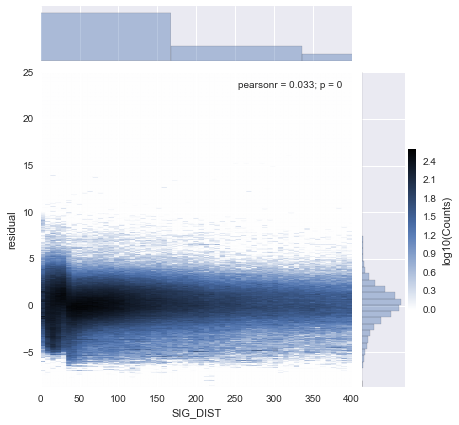

In [12]:
sns.jointplot(x="SIG_DIST", y="residual", data=data, bins="log", kind="hex", xlim=(0,400))
#sns.plt.xlabel("Distance to Nearest Intersection (m)")
#sns.plt.ylabel("Model Residual (m/s)")
#sns.plt.title("Histogram of Model Residual-Intersection Distance\nobservations")
cbar = sns.plt.colorbar()
cbar.set_label("log10(Counts)")

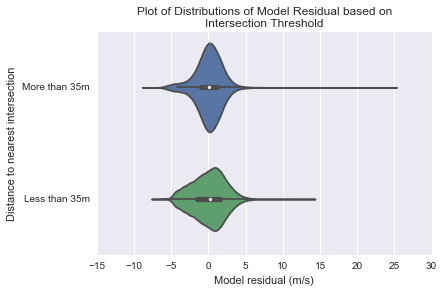

In [9]:
data["intersection"] = "More than 35m"
data.loc[data["SIG_DIST"] <= 35, "intersection"] = "Less than 35m"
sns.violinplot(x="residual", y="intersection", data=data)
sns.plt.ylabel("Distance to nearest intersection")
sns.plt.xlabel("Model residual (m/s)")
sns.plt.title("Plot of Distributions of Model Residual based on\nIntersection Threshold")

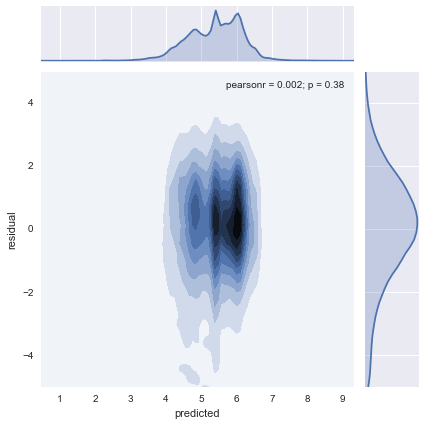

In [11]:
sns.jointplot(x="predicted", y="residual", data=data.sample(frac=0.1), 
              kind="kde", ylim=(-5, 5))

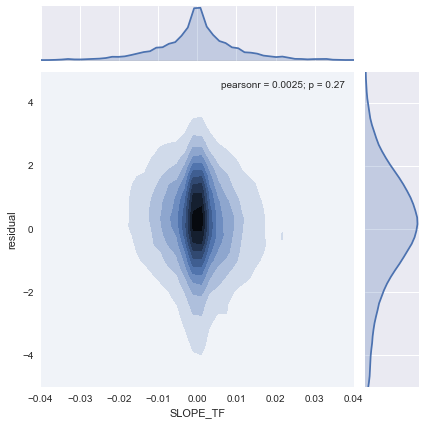

In [48]:
sns.jointplot(x="SLOPE_TF", y="residual", data=data.sample(frac=0.1), 
              kind="kde", xlim=(-0.04, 0.04), ylim=(-5, 5))

# Exporting Model Results

Having verified that the OLS assumptions more or less hold, there is some more certainty that the model accurately reflects real cyclist behaviour.

The residuals and predicted values can be aggregated into the links from the bicycle centreline dataset which the data was matched to.  This is accomplished by grouping on the centreline source ID, and then exporting the result of the aggregation to a CSV which can be joined directly to the centreline dataset in ArcGIS.

In [26]:
grouped = data.groupby("SOURCEOID")
link_aggregated = grouped.aggregate(
    {"residual": {"resid_mean": np.mean,
                  "resid_std": np.std,
                  "rmse": lambda x: np.sqrt(np.mean(x**2))},
     "predicted": {"predicted_mean": np.mean},
     "SPEED": {"speed_mean": np.mean,
               "counts": len,
               "speed_dev_from_network_mean": lambda x: np.mean(x) - data.SPEED.mean()},
     "APP_USER_I": {"unique_users": lambda x: len(np.unique(x))}})

link_aggregated.to_csv(os.path.join(MODEL_DIR, "link_with_model_data.csv"))

# Comparing with trip-specific attributes

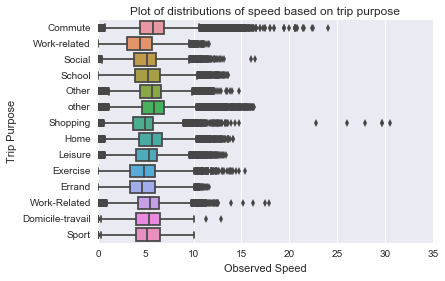

In [21]:
sns.boxplot(x="SPEED", y="PURPOSE", data=data)
sns.plt.ylabel("Trip Purpose")
sns.plt.xlabel("Observed Speed")
sns.plt.title("Plot of distributions of speed based on trip purpose")

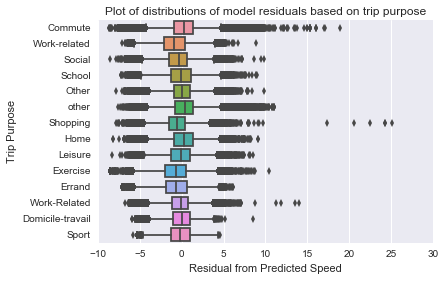

In [22]:
sns.boxplot(x="residual", y="PURPOSE", data=data)
sns.plt.ylabel("Trip Purpose")
sns.plt.xlabel("Residual from Predicted Speed")
sns.plt.title("Plot of distributions of model residuals based on trip purpose")

In [23]:
dates = pd.DatetimeIndex(data.RECORDED_A)
data["time_of_day"] = "Off Peak"
data.loc[(dates.hour >= 8) & (dates.hour < 10), "time_of_day"] = "AM Peak"
data.loc[(dates.hour >= 16) & (dates.hour < 19), "time_of_day"] = "PM Peak"

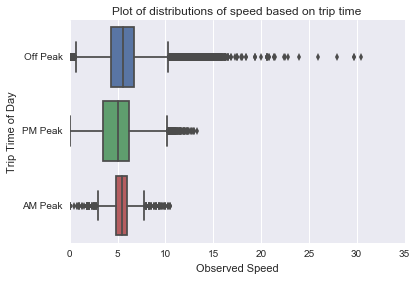

In [24]:
sns.boxplot(x="SPEED", y="time_of_day", data=data)
sns.plt.ylabel("Trip Time of Day")
sns.plt.xlabel("Observed Speed")
sns.plt.title("Plot of distributions of speed based on trip time")

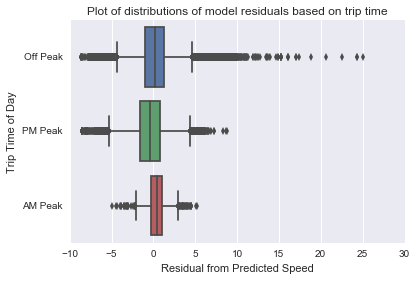

In [25]:
sns.boxplot(x="residual", y="time_of_day", data=data)
sns.plt.ylabel("Trip Time of Day")
sns.plt.xlabel("Residual from Predicted Speed")
sns.plt.title("Plot of distributions of model residuals based on trip time")